<a href="https://colab.research.google.com/github/rodrigobernall/ds4a_group30/blob/master/scripts/geo_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando las librerías

In [0]:
!pip install geopandas
import pandas as pd
import numpy as np
from google.colab import files
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd

# Cargando los datos

In [2]:
fp = 'https://www.dropbox.com/s/6s162261bj0i1za/geographic.csv?dl=1'
geographic = pd.read_csv(fp)
geographic.head()

,BK88,QN52,QN48,QN51,QN27,BX35,BX98,QN07,MN06,QN02,QN46,BK25,BX59,QN41,MN17,MN19,QN47,QN08,QN54,QN25,QN55,QN06,BK44,BK40,BK41,BK95,BX33,BK69,BX52,QN49,QN26,BK27,BK28,BK76,QN30,BK17,QN35,QN61,SI45,QN63,...,BX63,BX09,BX99,QN99,SI36,QN03,QN05,SI01,SI54,BK50,BK58,BK33,SI14,SI37,QN71,BK32,BK37,QN37,QN38,QN21,BK09,BK38,BK82,BK83,SI11,SI05,SI32,BK31,BK99,SI99,MN25,MN24,MN23,MN13,MN15,MN32,MN33,MN99,QN18,QN29
0,-73.976051,-73.794934,-73.775740,-73.803792,-73.861099,-73.896967,-73.872873,-73.757258,-73.946080,-73.760316,-73.767796,-73.958594,-73.839369,-73.777576,-73.973016,-73.961631,-73.767796,-73.752052,-73.816380,-73.857349,-73.805770,-73.756705,-73.937539,-73.980173,-73.970843,-73.948266,-73.894837,-73.953372,-73.839796,-73.791794,-73.854497,-74.002005,-73.979640,-73.932135,-73.888524,-73.918094,-73.793039,-73.768447,-74.084692,-73.898663,...,-73.911920,-73.880547,-73.869559,-73.865227,-74.065035,-73.757633,-73.725864,-74.221724,-74.144389,-73.888341,-73.918604,-73.992365,-74.081556,-74.072583,-73.928279,-73.987252,-73.973762,-73.814973,-73.796404,-73.859656,-73.992365,-73.979059,-73.861145,-73.863351,-74.207000,-74.195561,-74.203150,-74.032667,-73.915135,-74.118136,-74.000784,-73.992605,-73.989904,-74.001535,-73.993833,-73.938048,-73.935054,-74.010930,-73.858726,-73.867911
1,40.631284,40.757806,40.743334,40.775618,40.763673,40.834350,40.785983,40.718147,40.821271,40.675118,40.778754,40.610411,40.840891,40.730202,40.764287,40.755161,40.778754,40.705236,40.702460,40.747980,40.682941,40.726238,40.608566,40.661163,40.646387,40.638615,40.826255,40.680649,40.835627,40.789360,40.758287,40.594141,40.615573,40.728168,40.734539,40.586579,40.710719,40.709645,40.571486,40.759929,...,40.843266,40.818476,40.816168,40.570467,40.588999,40.666459,40.683249,40.502541,40.569714,40.646718,40.632077,40.689698,40.606299,40.637950,40.776907,40.660387,40.683058,40.738569,40.738291,40.713388,40.689698,40.705961,40.674338,40.679360,40.557576,40.635032,40.556070,40.643729,40.586278,40.550601,40.694295,40.724145,40.734443,40.762653,40.772940,40.780838,40.791695,40.684500,40.735717,40.744942
2,-73.977167,-73.794749,-73.775799,-73.800991,-73.859931,-73.896787,-73.872886,-73.755890,-73.946404,-73.758806,-73.767606,-73.958282,-73.839568,-73.778488,-73.971413,-73.962137,-73.767962,-73.751746,-73.816140,-73.854427,-73.805519,-73.756711,-73.938298,-73.980208,-73.970771,-73.949234,-73.894872,-73.953283,-73.839675,-73.791565,-73.854210,-74.002193,-73.980222,-73.932530,-73.888481,-73.918127,-73.793897,-73.769187,-74.085954,-73.899062,...,-73.911948,-73.880982,-73.869546,-73.864543,-74.065035,-73.757566,-73.725908,-74.221784,-74.142875,-73.888354,-73.918356,-73.992624,-74.077782,-74.072574,-73.927823,-73.987312,-73.973754,-73.814841,-73.796391,-73.859787,-73.994362,-73.979062,-73.861073,-73.863311,-74.208805,-74.192491,-74.203182,-74.032608,-73.915099,-74.116564,-74.000960,-73.992634,-73.989870,-74.001339,-73.993789,-73.937903,-73.935108,-74.011934,-73.858672,-73.867877
3,40.630755,40.755636,40.743326,40.775397,40.762209,40.834133,40.785971,40.716307,40.820580,40.673014,40.778307,40.608756,40.840556,40.729952,40.763596,40.754581,40.778784,40.704554,40.701946,40.748860,40.682416,40.726187,40.608071,40.661114,40.646119,40.638556,40.823946,40.680208,40.835609,40.789111,40.757876,40.594365,40.615013,40.727900,40.734166,40.586516,40.710361,40.709345,40.570306,40.759336,...,40.843184,40.818244,40.816103,40.569251,40.588918,40.666457,40.682665,40.502542,40.569090,40.646716,40.629804,40.689169,40.606179,40.637880,40.776706,40.660338,40.682998,40.737923,40.738242,40.713320,40.690248,40.705954,40.674028,40.679176,40.557317,40.633411,40.556000,40.643707,40.586275,40.549136,40.694077,40.724065,40.733535,40.762217,40.772912,40.780758,40.791658,40.683896,40.735627,40.744824
4,-73.977000,-73.794579,-73.778060,-73.798653,-73.859668,-73.896303,-73.872983,-73.754702,-73.946720,-73.758598,-73.767620,-73.957725,-73.839722,-73.779367,-73.969906,-73.962195,-73.768035,-73.751438,-73.815938,

# Functions

Function to find the polygon vertices for each column

In [0]:
def classify_lat_long(number):
    if number % 2 == 0:
        result = 'longitude'
    else:
        result = 'latitude'
    
    return result

def create_points_ids(test):
    id_point = []
    
    for i in range(len(test)):
        id_point.append(i)
        id_point.append(i)
    
    id_point = pd.Series(id_point)
        
    return id_point

def find_polygon_vertices_series(nta, nta_code):
    nta = pd.DataFrame(nta)
    nta = nta.dropna()
    long_lat = pd.Series(nta.index).apply(classify_lat_long)
    nta['long_lat'] = long_lat
    nta['id_points'] = create_points_ids(nta)
    result_df = nta.set_index('id_points').pivot(columns='long_lat')
    result_df['nta_code'] = nta_code
    result_df.columns = result_df.columns.droplevel(0)
    return result_df
    

def find_polygon_vertices_dataframe(geographic):
    columns_df = list(geographic.columns)
    
    result_df = pd.DataFrame()
    
    for i in columns_df:
        nta = geographic[i]
        result_intermediate_df = find_polygon_vertices_series(nta, i)
        #print(result_intermediate_df)
        result_df = pd.concat([result_df, result_intermediate_df], axis=0).dropna()
        
    #print(result_df.columns)
    result_df.columns = ['latitude', 'longitude', 'nta']
    return result_df   

def create_polygons(geographic):
    data = find_polygon_vertices_dataframe(geographic)
    data['points'] = data.loc[:, ['latitude', 'longitude']].apply(tuple, axis=1)
    nta_geo = data.groupby('nta')['points'].apply(list)
    nta_geo = pd.DataFrame(nta_geo)
    nta_geo['polygons'] = nta_geo['points'].apply(lambda row: Polygon(row))
    nta_geo = nta_geo.drop(columns=['points'])
    nta_geo.columns = ['geometry']
    nta_geo = gpd.GeoDataFrame(nta_geo)
    return nta_geo 

# Creating the polygons

In [0]:
nta_geo = create_polygons(geographic)

In [14]:
nta_geo.head()

,geometry
nta,
BK09,"POLYGON ((40.68970 -73.99237, 40.69025 -73.994..."
BK17,"POLYGON ((40.58658 -73.91809, 40.58652 -73.918..."
BK19,"POLYGON ((40.58731 -73.96035, 40.58652 -73.960..."
BK21,"POLYGON ((40.58315 -73.97459, 40.58301 -73.974..."
BK23,"POLYGON ((40.57527 -73.96889, 40.57529 -73.968..."


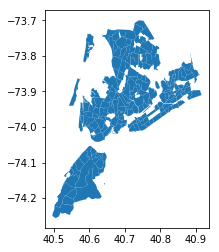

In [15]:
nta_geo.plot()

# Asignando los barrios a los puntos

In [0]:
url = 'https://www.dropbox.com/s/b09qj0x8749pu36/uber_trips_2014.csv.gz?dl=1'
uber_trips_2014 = pd.read_csv(url, compression='gzip')

In [0]:
url = 'https://www.dropbox.com/s/z1a8igph8cwpmcx/green_trips.csv.gz?dl=1'
green_trips = pd.read_csv(url, compression='gzip')

In [0]:
url = 'https://www.dropbox.com/s/3itjm0thz0m3031/yellow_trips.csv.gz?dl=1'
yellow_trips = pd.read_csv(url, compression='gzip')

In [0]:
def determine_if_in_polygon_vector(nta_name_list, dataframe, uber):
    if uber is False:
        dataframe['pickup_point'] = dataframe.loc[ : , ['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1) # Convert coordinates to tuples
        dataframe['pickup_point'] = dataframe['pickup_point'].apply(Point)
        dataframe['dropoff_point'] = dataframe.loc[ : , ['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1) # Convert coordinates to tuples
        dataframe['dropoff_point'] = dataframe['dropoff_point'].apply(Point)
        dataframe['pu_is_inside_this_nta'] = np.nan # Fill target series with NaN
        dataframe['do_is_inside_this_nta'] = np.nan # Fill target series with NaN
        for i in nta_name_list:
            poly = nta_geo['geometry'][i] # Pick a polygon
            for j in range( len(dataframe) ):
                point = dataframe['pickup_point'][j] # Pick a point
                inside = poly.contains(point) # Find out if the point is inside the polygon (using shapely). See https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html
                if inside is False:
                    continue # If there is no match yet, continue with the next point
                else:
                    dataframe.loc[j, 'pu_is_inside_this_nta'] = i # If there is a match, update the target series
            
            for k in range( len(dataframe) ):
                point = dataframe['dropoff_point'][k] # Pick a point
                inside = poly.contains(point) # Find out if the point is inside the polygon (using shapely). See https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html
                if inside is False:
                    continue # If there is no match yet, continue with the next point
                else:
                    dataframe.loc[k, 'do_is_inside_this_nta'] = i # If there is a match, update the target series
    else:
        dataframe['pickup_point'] = dataframe.loc[ : , ['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1) # Convert coordinates to tuples
        dataframe['pickup_point'] = dataframe['pickup_point'].apply(Point)
        dataframe['pu_is_inside_this_nta'] = np.nan # Fill target series with NaN
        for i in nta_name_list:
            poly = nta_geo['geometry'][i] # Pick a polygon
            for j in range( len(dataframe) ):
                point = dataframe['pickup_point'][j] # Pick a point
                inside = poly.contains(point) # Find out if the point is inside the polygon (using shapely). See https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html
                if inside is False:
                    continue # If there is no match yet, continue with the next point
                else:
                    dataframe.loc[j, 'pu_is_inside_this_nta'] = i # If there is a match, update the target series
    return dataframe

In [0]:
amount = 2000

from time import perf_counter

t1_start = perf_counter()
nta_name_list = list(nta_geo.index)
test = yellow_trips.copy().head(amount)
#test = 
test = determine_if_in_polygon_vector(nta_name_list, test, uber=False)

t1_stop = perf_counter() 

print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)
print("Amount: ", amount)
print("Time per 100:", (t1_stop-t1_start)*100/amount)
print("Time per vector (hrs):", (t1_stop-t1_start)*len(yellow_trips)/(amount*3600))

Elapsed time during the whole program in seconds: 19.752598385000965
Amount:  2000
Time per 100: 0.9876299192500483
Time per vector (hrs): 21.87616457295867


In [0]:
test

In [0]:
test1 = gpd.GeoDataFrame(test.set_index('pickup_point'))
test2 = gpd.GeoDataFrame(nta_geo, crs = {'init': 'epsg:4326'}, geometry=nta_geo['geometry'])
test2.head()#.type
gpd.sjoin(test1, test2)#, how="inner", op='intersects' )
#test2.index

In [0]:
yellow_trips
gdf = gpd.GeoDataFrame(df.drop(['x', 'y'], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df.x, df.y)])


,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,total_amount
0,2014-04-03 18:28:10,2014-04-03 18:54:32,-74.006033,40.706284,-73.918837,40.744946,1,8.70,34.80
1,2014-04-16 15:42:00,2014-04-16 16:07:00,-73.979558,40.749357,0.000000,0.000000,1,9.37,30.00
2,2014-04-13 18:04:00,2014-04-13 18:07:00,-73.956453,40.775307,-73.954792,40.784992,1,0.89,6.50
3,2014-05-21 19:33:00,2014-05-21 19:45:00,-73.987212,40.757850,-73.960198,40.775472,1,2.40,12.50
4,2014-05-30 16:28:00,2014-05-30 16:51:00,-73.974292,40.755397,-74.011867,40.704222,3,5.58,24.50
5,2014-05-11 13:09:24,2014-05-11 13:19:18,-73.978131,40.748238,-73.984475,40.749268,1,1.30,11.05
6,2014-05-05 16:46:00,2014-05-05 16:49:00,-73.994868,40.745097,-74.004258,40.731687,2,1.10,8.30
7,2014-05-19 01:24:51,2014-05-19 01:37:11,-73.974711,40.764945,-73.916280,40.766681,1,4.00,15.50
8,2014-05-26 01:12:14,2014-05-26 01:34:44,-73.988324,40.723345,-73.953039,40.809264,1,7.50,24.50
9,2014-05-09 18:45:09,2014-05-09 18:57:12,-73.969744,40.753129,-73.988274,40.727640,1,2.00,13.80
